In [677]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import time
import seaborn as sns

## Necessary Functions

In [678]:
def flops_matmul(n, m, p):
    """multiplication of matrix (n x m) by (m x p)"""
    return 2 * n * m * p

### Standardization

In [679]:
def standardize(X):
    if X.size == 0:
        raise ValueError("Input array X is empty.")
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    if np.any(std_dev == 0):
        raise ValueError("Standard deviation is zero for one or more features, cannot standardize.")
    X_std = (X - mean) / std_dev
    return X_std

### Covariance Matrix Generator

In [680]:
def covariance_matrix(X):
    if X.size == 0:
        raise ValueError("Input array X is empty.")
    m = X.shape[0]
    return (1 / (m - 1)) * X.T @ X

In [681]:
def householder_reflection(a):
    """
    Compute the Householder vector for a given vector a.
    
    Args:
    a -- (m,) vector
    
    Returns:
    v -- (m,) Householder vector
    """
    e = np.zeros_like(a)
    e[0] = np.linalg.norm(a) * (1 if a[0] >= 0 else -1)
    u = a - e
    v = u / np.linalg.norm(u)
    return v

In [682]:
def qr_decomp(A, max_iter=100, tol=1e-8):
    if isinstance(A, pd.DataFrame):
        A = A.values

    n, m = A.shape
    Q = np.eye(n)
    R = A.copy()

    for i in range(min(n, m, max_iter)):
        x = R[i:, i]
        if np.max(np.abs(x)) < tol:
            break
        
        e = np.zeros_like(x)
        e[0] = norm(x)
        u = x - e
        u /= norm(u)

        H = np.eye(n)
        H[i:, i:] -= 2.0 * np.outer(u, u)
        R = H @ R
        Q = Q @ H.T

    return Q, R

In [683]:
def form_q(Q_stored, m, n):
    Q = np.eye(m, n)
    for i,v in enumerate(Q_stored):
        H = np.eye(m-i) - 2 * np.outer(v, v)
        Q[i:, i:] = H @ Q[i:, i:]
        return Q[:, :n]

In [684]:
def qr_decomp_storedq(A, max_iter=100, tol=1e-8):
    """
    Perform QR decomposition using Householder transformations and store the Q vectors.
    
    Args:
    A -- (n, m) matrix or DataFrame
    max_iter -- maximum number of iterations
    tol -- tolerance for stopping criterion
    
    Returns:
    Q_stored -- list of Householder vectors
    R -- (n, m) upper triangular matrix
    """
    if isinstance(A, pd.DataFrame):
        A = A.values

    n, m = A.shape
    R = A.copy()
    Q_stored = []

    for i in range(min(n, m, max_iter)):
        x = R[i:, i]
        if np.max(np.abs(x)) < tol:
            break
        
        # Compute Householder vector
        norm_x = np.linalg.norm(x)
        sign = -np.sign(x[0]) if x[0] != 0 else 1
        v = x.copy()
        v[0] -= sign * norm_x
        v /= np.linalg.norm(v)
        Q_stored.append(v)
        
        # Apply Householder transformation to R
        H = np.eye(n)
        H[i:, i:] -= 2.0 * np.outer(v, v)
        R = H @ R

    return Q_stored, R

In [685]:
def eigen_decomp(A, max_iter=100, tol=1e-8):
    n = A.shape[0]
    A_k = A.copy()
    Q_total = np.eye(n)
    
    for _ in range(max_iter):
        Q, R = qr_decomp(A_k)
        A_k = R @ Q
        Q_total = Q_total @ Q
        
        if np.allclose(A_k - np.diag(np.diagonal(A_k)), 0, atol=tol):
            break

    eigenvalues = np.diagonal(A_k)
    eigenvectors = Q_total

    for i in range(n):
        eigenvectors[:, i] /= norm(eigenvectors[:, i])

    return eigenvalues, eigenvectors

In [686]:
def eigen_decomp_storedq(A, max_iter=100, tol=1e-8):
    n = A.shape[0]
    A_k = A.copy()
    Q_total = np.eye(n)
    
    for _ in range(max_iter):
        Q_stored, R = qr_decomp_storedq(A_k)
        Q = form_q(Q_stored, n, n)
        A_k = R @ Q
        Q_total = Q_total @ Q
        
        if np.allclose(A_k - np.diag(np.diagonal(A_k)), 0, atol=tol):
            break

    eigenvalues = np.diagonal(A_k)
    eigenvectors = Q_total

    for i in range(n):
        eigenvectors[:, i] /= norm(eigenvectors[:, i])

    return eigenvalues, eigenvectors

In [687]:
def reduced_qr_decomp_storedq(A):
    m,n = A.shape
    R = A.copy()
    Q_stored = []

    for i in range(n):
        a = R[i:, i]
        v = householder_reflection(a)
        Q_stored.append(v)
        H = np.eye(m-i) - 2 * np.outer(v, v)
        R[i:, i:] = H @ R[i:, i:]

    return Q_stored, R[:n, :]

In [688]:
def reduced_qr_decomp(A):
    """
    Perform reduced QR decomposition using Householder transformations.
    
    Args:
    A -- (m, n) matrix with m >= n
    
    Returns:
    Q -- (m, n) orthonormal matrix
    R -- (n, n) upper triangular matrix
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    
    for i in range(n):
        a = R[i:, i]

        v = householder_reflection(a)
        
        H = np.eye(m)
        H[i:, i:] -= 2.0 * np.outer(v, v)
        
        R = H @ R
        
        Q = Q @ H
    
    return Q[:, :n], R[:n, :]

In [689]:
def pca(X, threshold):
    X_std = standardize(X)
    cov_matrix = covariance_matrix(X_std)
    eigenvalues, eigenvectors = eigen_decomp(cov_matrix)
    total_variance = np.sum(eigenvalues)
    variance_ratio = eigenvalues / total_variance
    cumulative_variance_ratio = np.cumsum(variance_ratio)
    print(f"Explained variance ratio: {cumulative_variance_ratio}")
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    V_k  = eigenvectors[:, :n_components]
    Z = np.dot(X_std, V_k)

    return Z, V_k, n_components

In [690]:
def pca_q_stored(X, threshold):
    X_std = standardize(X)
    cov_matrix = covariance_matrix(X_std)
    eigenvalues, eigenvectors = eigen_decomp_storedq(cov_matrix)
    total_variance = np.sum(eigenvalues)
    variance_ratio = eigenvalues / total_variance
    cumulative_variance_ratio = np.cumsum(variance_ratio)
    print(f"Explained variance ratio: {cumulative_variance_ratio}")
    n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
    V_k = eigenvectors[:, :n_components]
    Z = np.dot(X_std, V_k)

    return Z, V_k, n_components

In [691]:
def normal_equation(X, y):
    if X.size == 0 or y.size == 0:
        raise ValueError("Input arrays X or y are empty.")
    
    flops = flops_matmul(X.shape[1], X.shape[0], X.shape[1])
    flops += (2/3) * X.shape[0] ** 3 
    flops += flops_matmul(X.shape[0], X.shape[1], 1)
    return np.linalg.inv(X.T @ X) @ X.T @ y, flops

In [692]:
def qr_equation(X, y):
    if X.size == 0 or y.size == 0:
        raise ValueError("Input arrays X or y are empty.")
    Q, R = reduced_qr_decomp(X)
    return np.linalg.inv(R) @ Q.T @ y

In [693]:
def qr_storedq_equation(X, y):
    if X.size == 0 or y.size == 0:
        raise ValueError("Input arrays X or y are empty.")
    Q_stored, R = reduced_qr_decomp_storedq(X)
    Q = form_q(Q_stored, X.shape[0], X.shape[1])
    return np.linalg.inv(R) @ Q.T @ y

In [694]:
def mean_square_error(y_true, y_pred):
    if y_true.size == 0 or y_pred.size == 0:
        raise ValueError("Input arrays y_true or y_pred are empty.")
    return np.mean((y_true - y_pred) ** 2)

In [695]:
def residual_error_norm(y, predictions):
    residuals = y - predictions
    norm = np.linalg.norm(residuals)
    return norm

In [696]:
def backwards_substitution(U, b):
    n = U.shape[0]
    x = np.zeros_like(b)

    for i in range(n - 1, -1, -1):
        x[i] = (b[i] - U[i, i + 1:] @ x[i + 1:]) / U[i, i]

    return x

## Code Execution

### Open the dataset

In [697]:
df = pd.read_csv("pokindex_data.csv")
df

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,WinningPercentage
0,70,90,45,15,45,50,36.290323
1,40,27,60,37,50,66,36.220472
2,75,75,60,83,60,60,39.344262
3,85,115,80,105,80,50,30.630631
4,83,106,65,86,65,85,66.406250
...,...,...,...,...,...,...,...
195,50,65,64,44,48,43,21.969697
196,60,85,69,65,79,80,57.600000
197,45,50,43,40,38,62,40.441176
198,55,45,50,45,65,80,55.462185


In [698]:
X_df = df.iloc[:, :-1]
X_df

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,70,90,45,15,45,50
1,40,27,60,37,50,66
2,75,75,60,83,60,60
3,85,115,80,105,80,50
4,83,106,65,86,65,85
...,...,...,...,...,...,...
195,50,65,64,44,48,43
196,60,85,69,65,79,80
197,45,50,43,40,38,62
198,55,45,50,45,65,80


### Get the Z dataset, transformation matrix, and optimal k for PCA

In [699]:
Z, V_k, n_components = pca(X_df, 0.90)

principal_components = pd.DataFrame(data=Z, columns=[f"PC{i+1}" for i in range(n_components)])
principal_components

Explained variance ratio: [0.48906619 0.6884508  0.81702026 0.90237587 0.96466054 1.        ]


,PC1,PC2,PC3,PC4
0,-1.535627,-0.154778,1.611419,-0.254967
1,-2.275202,0.056187,-0.462071,0.245586
2,-0.189388,0.231696,0.275896,-0.565281
3,1.349380,-0.343314,0.508127,-0.342828
4,0.844757,0.760486,0.784812,-0.193403
...,...,...,...,...
195,-1.663667,-0.442388,0.429042,0.223010
196,0.046590,0.240373,-0.067483,0.364742
197,-2.262974,0.467138,0.279696,0.126750
198,-1.359104,0.494743,-0.351214,-0.124375


In [700]:
V_k

array([[ 0.43354602, -0.06079581,  0.39576925, -0.77440082],
       [ 0.44686717,  0.06341416,  0.57662133,  0.39600225],
       [ 0.3863902 , -0.57758994,  0.03447059,  0.41114815],
       [ 0.44243289,  0.30046001, -0.38034996, -0.09211424],
       [ 0.42577579, -0.27598307, -0.6008831 , -0.07390754],
       [ 0.29328878,  0.7015907 , -0.06292642,  0.2459582 ]])

In [701]:
n_components

np.int64(4)

### PCA using Stored Q method

In [702]:
principal_storedq, V_k_storedq, k_storedq = pca_q_stored(X_df, 0.90) 
principal_storedq = pd.DataFrame(data=principal_storedq, columns=[f"PC{i+1}" for i in range(k_storedq)])

principal_storedq

Explained variance ratio: [0.44796201 0.55280409 0.70163369 0.82993892 0.90064115 1.        ]


,PC1,PC2,PC3,PC4,PC5
0,-0.537132,0.423876,-0.879292,-1.805100,-0.948339
1,-1.851151,-1.262020,-0.110382,-0.943015,-0.381740
2,0.107583,-0.148465,-0.492748,0.249926,-0.531150
3,1.127193,0.966298,-0.002268,0.859155,-0.008021
4,0.861870,0.725371,-0.443873,0.293580,-0.513194
...,...,...,...,...,...
195,-1.290005,-0.184530,-0.100379,-0.798986,-0.626304
196,-0.137563,0.308399,-0.091209,-0.206452,0.323160
197,-1.734200,-0.588903,-0.711784,-0.888902,-0.901929
198,-0.936602,-0.856906,-0.594045,-0.783439,-0.028877


## Linear Regression

In [703]:
times = []
residuals = []

In [704]:
y = df.iloc[:, -1]
y

0      36.290323
1      36.220472
2      39.344262
3      30.630631
4      66.406250
         ...    
195    21.969697
196    57.600000
197    40.441176
198    55.462185
199    60.800000
Name: WinningPercentage, Length: 200, dtype: float64

### Normal equation

In [705]:
X = np.c_[np.ones(principal_components.shape[0]), principal_components]

normal_start = time.time()
theta_normal, normal_flops = normal_equation(X, y)
normal_end = time.time()

y_pred_normal = pd.Series(np.dot(X, theta_normal))
y_pred_normal

0      35.029023
1      32.274892
2      48.278115
3      54.918159
4      68.328011
         ...    
195    31.295163
196    56.409055
197    38.697193
198    44.247542
199    55.378288
Length: 200, dtype: float64

In [706]:
print(f"Flops for normal equation: {normal_flops}")

Flops for normal equation: 5345333.333333333


In [707]:
normal_time = normal_end - normal_start
print(f"Normal equation took {normal_time} seconds.")

Normal equation took 0.00046324729919433594 seconds.


In [708]:
normal_error = residual_error_norm(y, y_pred_normal)
print(f"Residual error norm for normal equation: {normal_error}")

Residual error norm for normal equation: 151.05931586221917


In [709]:
times.append(normal_time)
residuals.append(normal_error)

### Direct QR decomposition (Householder transformation)

In [710]:
qr_start = time.time()
theta_qr = qr_equation(X, y)
qr_end = time.time()

In [711]:
y_pred_qr = pd.Series(np.dot(X, theta_qr))
y_pred_qr

0      35.029023
1      32.274892
2      48.278115
3      54.918159
4      68.328011
         ...    
195    31.295163
196    56.409055
197    38.697193
198    44.247542
199    55.378288
Length: 200, dtype: float64

In [712]:
print(f"Time for QR equation: {(qr_end - qr_start)} seconds.")

Time for QR equation: 0.060651302337646484 seconds.


In [713]:
qr_error = residual_error_norm(y, y_pred_qr)
print(f"Residual error norm for QR with Q equation: {qr_error}")

Residual error norm for QR with Q equation: 151.05931586221917


In [714]:
times.append(qr_end - qr_start)
residuals.append(qr_error)

### Stored Q QR decomposition (Householder transformation)

In [715]:
qr_stored_q_start = time.time()
theta_storedq = qr_storedq_equation(X, y)
qr_stored_q_end = time.time()

In [716]:
y_pred_storedq = pd.Series(np.dot(X, theta_storedq))
y_pred_storedq

0      46.928167
1      48.966610
2      50.127169
3      50.785957
4      48.959204
         ...    
195    48.287434
196    49.419634
197    47.623067
198    49.574273
199    48.027034
Length: 200, dtype: float64

In [717]:
error_qr_storedq = residual_error_norm(y, y_pred_storedq)
print(f"Residual error norm for QR with stored Q equation: {error_qr_storedq}")

Residual error norm for QR with stored Q equation: 356.4989346713022


In [718]:
print(f"Time for QR with stored Q equation: {(qr_stored_q_end - qr_stored_q_start)} seconds.")

Time for QR with stored Q equation: 0.0012135505676269531 seconds.


In [719]:
times.append(qr_stored_q_end - qr_stored_q_start)
residuals.append(error_qr_storedq)

## Results

In [720]:
data = {
    "Method": ["Normal Equation", "QR Equation", "QR Equation with Stored Q"],
    "Time (s)": times,
    "Residual Error Norm": residuals
}

result_df = pd.DataFrame(data)
result_df

,Method,Time (s),Residual Error Norm
0,Normal Equation,0.000463,151.059316
1,QR Equation,0.060651,151.059316
2,QR Equation with Stored Q,0.001214,356.498935


<Axes: xlabel='Time (s)', ylabel='Method'>

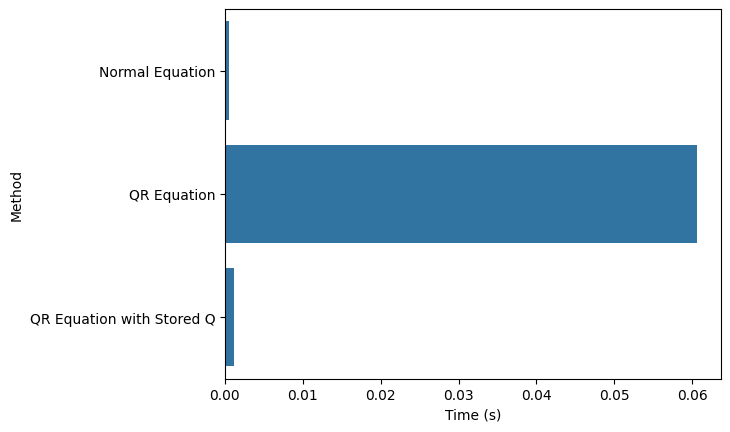

In [721]:
sns.barplot(x="Time (s)", y="Method", data=result_df)

<Axes: xlabel='Residual Error Norm', ylabel='Method'>

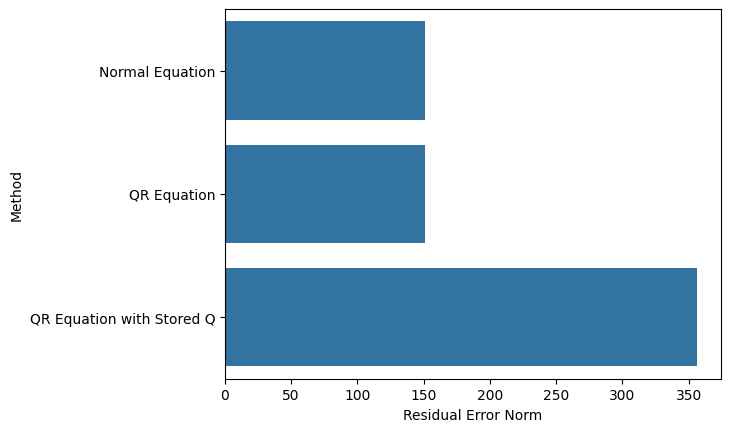

In [733]:
sns.barplot(x="Residual Error Norm", y="Method", data=result_df)

### Data without outlier using the Normal Equation

In [722]:
no_outlier_df = pd.read_csv("pokindex_data_nooutlier.csv")
no_outlier_df

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,WinningPercentage
0,70,90,45,15,45,50,36.290323
1,40,27,60,37,50,66,36.220472
2,75,75,60,83,60,60,39.344262
3,85,115,80,105,80,50,30.630631
4,83,106,65,86,65,85,66.406250
...,...,...,...,...,...,...,...
179,50,65,64,44,48,43,21.969697
180,60,85,69,65,79,80,57.600000
181,45,50,43,40,38,62,40.441176
182,55,45,50,45,65,80,55.462185


In [723]:
X_no_outlier_df = no_outlier_df.iloc[:, :-1]
X_no_outlier_df

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,70,90,45,15,45,50
1,40,27,60,37,50,66
2,75,75,60,83,60,60
3,85,115,80,105,80,50
4,83,106,65,86,65,85
...,...,...,...,...,...,...
179,50,65,64,44,48,43
180,60,85,69,65,79,80
181,45,50,43,40,38,62
182,55,45,50,45,65,80


In [724]:
X_no_outlier_std = standardize(X_no_outlier_df)
X_no_outlier_std

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,0.281459,0.524904,-0.942009,-1.831199,-1.030554,-0.641841
1,-1.255290,-1.658336,-0.362828,-1.102321,-0.819675,-0.058457
2,0.537584,0.005085,-0.362828,0.421698,-0.397918,-0.277226
3,1.049834,1.391270,0.409414,1.150577,0.445595,-0.641841
4,0.947384,1.079378,-0.169767,0.521091,-0.187040,0.634311
...,...,...,...,...,...,...
179,-0.743041,-0.341461,-0.208379,-0.870405,-0.904027,-0.897072
180,-0.230791,0.351631,-0.015319,-0.174657,0.403420,0.452004
181,-0.999165,-0.861280,-1.019233,-1.002928,-1.325783,-0.204303
182,-0.486916,-1.034553,-0.748948,-0.837274,-0.187040,0.452004


In [725]:
cov_matrix_no_outlier = covariance_matrix(X_no_outlier_std)
cov_matrix_no_outlier

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
HP,1.005464,0.577163,0.469326,0.419522,0.493828,0.263993
Attack,0.577163,1.005464,0.536234,0.396956,0.299295,0.377378
Defense,0.469326,0.536234,1.005464,0.226107,0.569609,0.003423
Sp. Atk,0.419522,0.396956,0.226107,1.005464,0.557707,0.504540
Sp. Def,0.493828,0.299295,0.569609,0.557707,1.005464,0.247565
Speed,0.263993,0.377378,0.003423,0.504540,0.247565,1.005464


In [726]:
eigenvalues_no_outlier, eigenvectors_no_outlier = eigen_decomp(cov_matrix_no_outlier)

print(eigenvalues_no_outlier)
print(eigenvectors_no_outlier)

[3.02292626 1.15561446 0.78339176 0.48381804 0.3862541  0.20078226]
[[ 4.48805592e-01 -1.41864158e-01  2.09458644e-01 -7.94845686e-01
   2.60997608e-01  1.86214288e-01]
 [ 4.35537462e-01 -6.25359534e-02  6.34115270e-01  1.96910903e-01
  -3.31358658e-01 -5.05689366e-01]
 [ 3.91057714e-01 -5.68664281e-01 -7.93464798e-04  4.73103254e-01
   7.26372415e-02  5.42762667e-01]
 [ 4.18565976e-01  3.96964859e-01 -3.53707329e-01 -8.46728991e-02
  -6.76443225e-01  2.78150343e-01]
 [ 4.37304898e-01 -1.35865207e-01 -6.29906415e-01  6.80385892e-02
   2.83274153e-01 -5.55562314e-01]
 [ 2.99201394e-01  6.90321879e-01  1.79257648e-01  3.06302128e-01
   5.28191099e-01  1.70276521e-01]]


In [727]:
Z_no_outlier, V_k_no_outlier, n_components_no_outlier = pca(X_no_outlier_df, 0.90)
print(V_k_no_outlier)
print(n_components_no_outlier)

Explained variance ratio: [0.50108289 0.69263854 0.82249424 0.90269234 0.96671816 1.        ]
[[ 4.48805592e-01 -1.41864158e-01  2.09458644e-01 -7.94845686e-01]
 [ 4.35537462e-01 -6.25359534e-02  6.34115270e-01  1.96910903e-01]
 [ 3.91057714e-01 -5.68664281e-01 -7.93464798e-04  4.73103254e-01]
 [ 4.18565976e-01  3.96964859e-01 -3.53707329e-01 -8.46728991e-02]
 [ 4.37304898e-01 -1.35865207e-01 -6.29906415e-01  6.80385892e-02]
 [ 2.99201394e-01  6.90321879e-01  1.79257648e-01  3.06302128e-01]]
4


In [728]:
pca_no_outlier = pd.DataFrame(data=Z_no_outlier, columns=[f"PC{i+1}" for i in range(n_components_no_outlier)])
pca_no_outlier

,PC1,PC2,PC3,PC4
0,-1.422628,-0.567050,1.574357,-0.677686
1,-2.264868,0.121542,-0.418481,0.519224
2,0.021149,0.159832,0.167913,-0.745645
3,1.721639,-0.515637,0.299092,-0.630507
4,1.155016,0.564787,0.930232,-0.483357
...,...,...,...,...
179,-1.591750,-0.596700,0.344517,0.162196
180,0.282130,0.207347,0.063332,0.426122
181,-2.282821,0.416174,0.398614,0.074522
182,-1.259007,0.564745,-0.262428,0.025596


In [729]:
X_no_outlier = np.c_[np.ones(pca_no_outlier.shape[0]), pca_no_outlier]
y_no_outlier = no_outlier_df.iloc[:, -1]

print(y_no_outlier)
print(X_no_outlier)


0      36.290323
1      36.220472
2      39.344262
3      30.630631
4      66.406250
         ...    
179    21.969697
180    57.600000
181    40.441176
182    55.462185
183    60.800000
Name: WinningPercentage, Length: 184, dtype: float64
[[ 1.00000000e+00 -1.42262756e+00 -5.67050180e-01  1.57435735e+00
  -6.77686230e-01]
 [ 1.00000000e+00 -2.26486787e+00  1.21541790e-01 -4.18481157e-01
   5.19224301e-01]
 [ 1.00000000e+00  2.11492150e-02  1.59832373e-01  1.67912797e-01
  -7.45645002e-01]
 [ 1.00000000e+00  1.72163913e+00 -5.15636691e-01  2.99091601e-01
  -6.30506883e-01]
 [ 1.00000000e+00  1.15501604e+00  5.64786582e-01  9.30231859e-01
  -4.83357245e-01]
 [ 1.00000000e+00  3.50393397e-01 -8.73515267e-01  3.06030694e-01
  -1.71766874e+00]
 [ 1.00000000e+00  1.02045756e+00 -8.88399156e-01  9.52553577e-03
   1.01144328e+00]
 [ 1.00000000e+00  6.42387228e-01 -1.13643598e+00 -3.62379674e-01
   1.43790834e+00]
 [ 1.00000000e+00 -4.51907033e-01 -1.32921714e+00 -5.73564985e-01
   4.83750152e

In [730]:
theta_normal_without_outlier, _ = normal_equation(X_no_outlier, y_no_outlier)
theta_normal_without_outlier

array([49.30751232,  8.69087937, 13.77761588,  6.40859288,  8.2407886 ])

In [731]:
y_pred_normal_without_outlier = pd.Series(np.dot(X_no_outlier, theta_normal_without_outlier))
y_pred_normal_without_outlier

0      33.635775
1      32.895317
2      46.624809
3      53.886708
4      69.105262
         ...    
179    30.797189
180    58.533670
181    38.370348
182    44.675612
183    58.907385
Length: 184, dtype: float64

In [732]:
error_qr_without_outlier = residual_error_norm(y_no_outlier, y_pred_normal_without_outlier)
error_qr_without_outlier

np.float64(129.5704305406556)